# Brazilian E-Commerce Data Analysis
This notebook contains comprehensive visualizations of the Olist E-Commerce dataset, analyzing various aspects of the business including sales, customers, orders, and sellers.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import warnings
import matplotlib_inline
# Configure plot settings
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Set figure size and DPI for better visibility
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting
%matplotlib inline

In [2]:
# Database connection
from sqlalchemy import create_engine
import os

# Database connection parameters
db_params = {
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'apple'),
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', '5432'),
    'database': 'commerce'
}

# Create SQLAlchemy engine
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}")

## 1. Sales Analysis
Let's analyze sales trends, category performance, and revenue distribution.

In [14]:
try:
    # Query sales data
    sales_query = """
    SELECT 
    s.sales_month,
    COUNT(DISTINCT s.order_id) AS total_orders,
    SUM(s.price) AS total_revenue
FROM 
    sales_overview s
WHERE 
    s.order_status = 'delivered'
    AND s.order_purchase_timestamp >= NOW() - INTERVAL '1 year'
GROUP BY 
    s.sales_month
ORDER BY 
    s.sales_month; """
    sales_df = pd.read_sql(sales_query, engine)

    ## Convert to datetime (for x-axis)
    sales_df['sales_month'] = pd.to_datetime(sales_df['sales_month'])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=sales_df, x='sales_month', y='total_revenue', ax=ax, label='Revenue')
    sns.lineplot(data=sales_df, x='sales_month', y='total_orders', ax=ax, label='Orders')
    ax.set_title('Monthly Sales Trends')
    ax.set_xlabel('Month')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.show()


except Exception as e:
    print(f"Error in sales analysis: {str(e)}")
    raise

Error in sales analysis: (psycopg2.errors.UndefinedColumn) column s.order_status does not exist
LINE 9:     s.order_status = 'delivered'
            ^

[SQL: 
    SELECT 
    s.sales_month,
    COUNT(DISTINCT s.order_id) AS total_orders,
    SUM(s.price) AS total_revenue
FROM 
    sales_overview s
WHERE 
    s.order_status = 'delivered'
    AND s.order_purchase_timestamp >= NOW() - INTERVAL '1 year'
GROUP BY 
    s.sales_month
ORDER BY 
    s.sales_month; ]
(Background on this error at: https://sqlalche.me/e/20/f405)


ProgrammingError: (psycopg2.errors.UndefinedColumn) column s.order_status does not exist
LINE 9:     s.order_status = 'delivered'
            ^

[SQL: 
    SELECT 
    s.sales_month,
    COUNT(DISTINCT s.order_id) AS total_orders,
    SUM(s.price) AS total_revenue
FROM 
    sales_overview s
WHERE 
    s.order_status = 'delivered'
    AND s.order_purchase_timestamp >= NOW() - INTERVAL '1 year'
GROUP BY 
    s.sales_month
ORDER BY 
    s.sales_month; ]
(Background on this error at: https://sqlalche.me/e/20/f405)

## 2. Category Analysis
Analyzing product categories and their performance

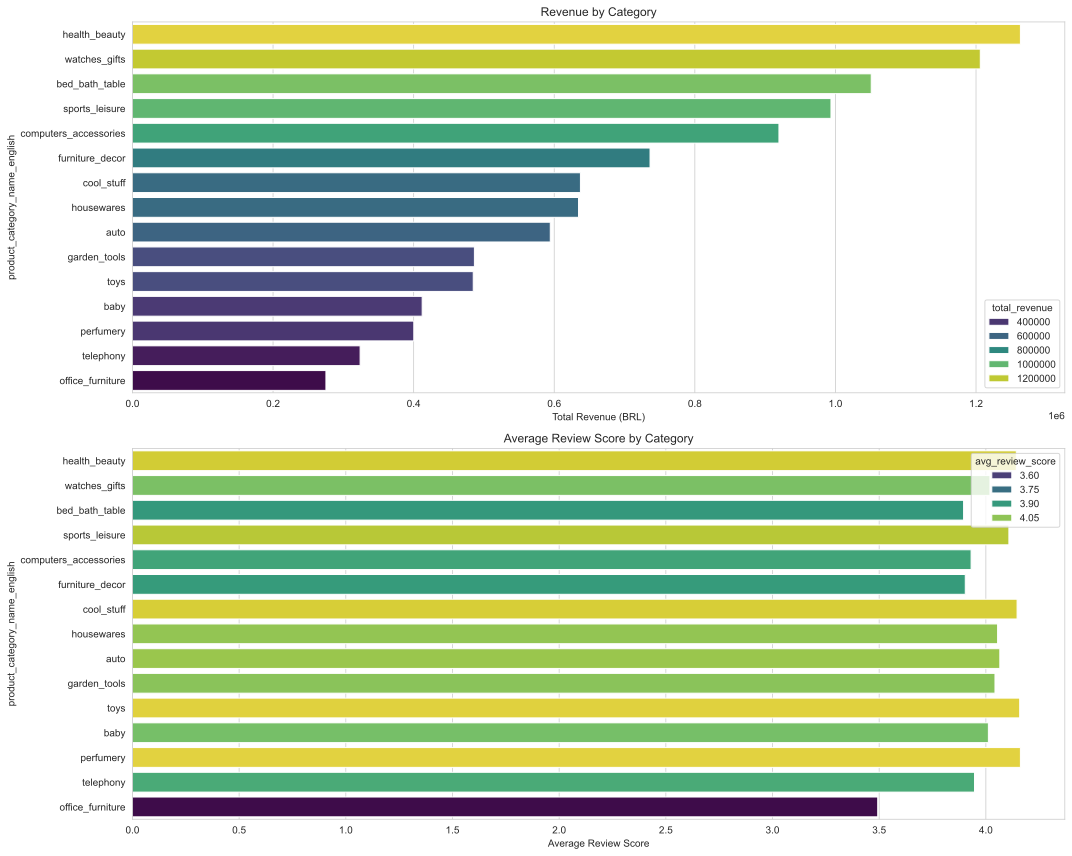

In [10]:
# Query category performance
category_query = """
SELECT 
    pct.product_category_name_english,
    COUNT(DISTINCT oi.order_id) as total_orders,
    SUM(oi.price) as total_revenue,
    AVG(r.review_score) as avg_review_score
FROM 
    order_items oi
    JOIN products p ON oi.product_id = p.product_id
    JOIN product_category_translation pct ON p.product_category_name = pct.product_category_name
    LEFT JOIN order_reviews r ON oi.order_id = r.order_id
GROUP BY 
    pct.product_category_name_english
ORDER BY 
    total_revenue DESC
LIMIT 15
"""
category_df = pd.read_sql(category_query, engine)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot revenue by category
sns.barplot(data=category_df, 
           x='total_revenue', 
           y='product_category_name_english',
           ax=ax1,
           hue='total_revenue',
           palette='viridis')
ax1.set_title('Revenue by Category')
ax1.set_xlabel('Total Revenue (BRL)')

# Plot average review score by category
sns.barplot(data=category_df,
           x='avg_review_score',
           y='product_category_name_english',
           ax=ax2,
           hue='avg_review_score',
           palette='viridis')
ax2.set_title('Average Review Score by Category')
ax2.set_xlabel('Average Review Score')

plt.tight_layout()
plt.savefig('../plots/category_analysis.png', dpi=300)
plt.show()

## 3. Customer Analysis
Analyzing customer distribution and behavior

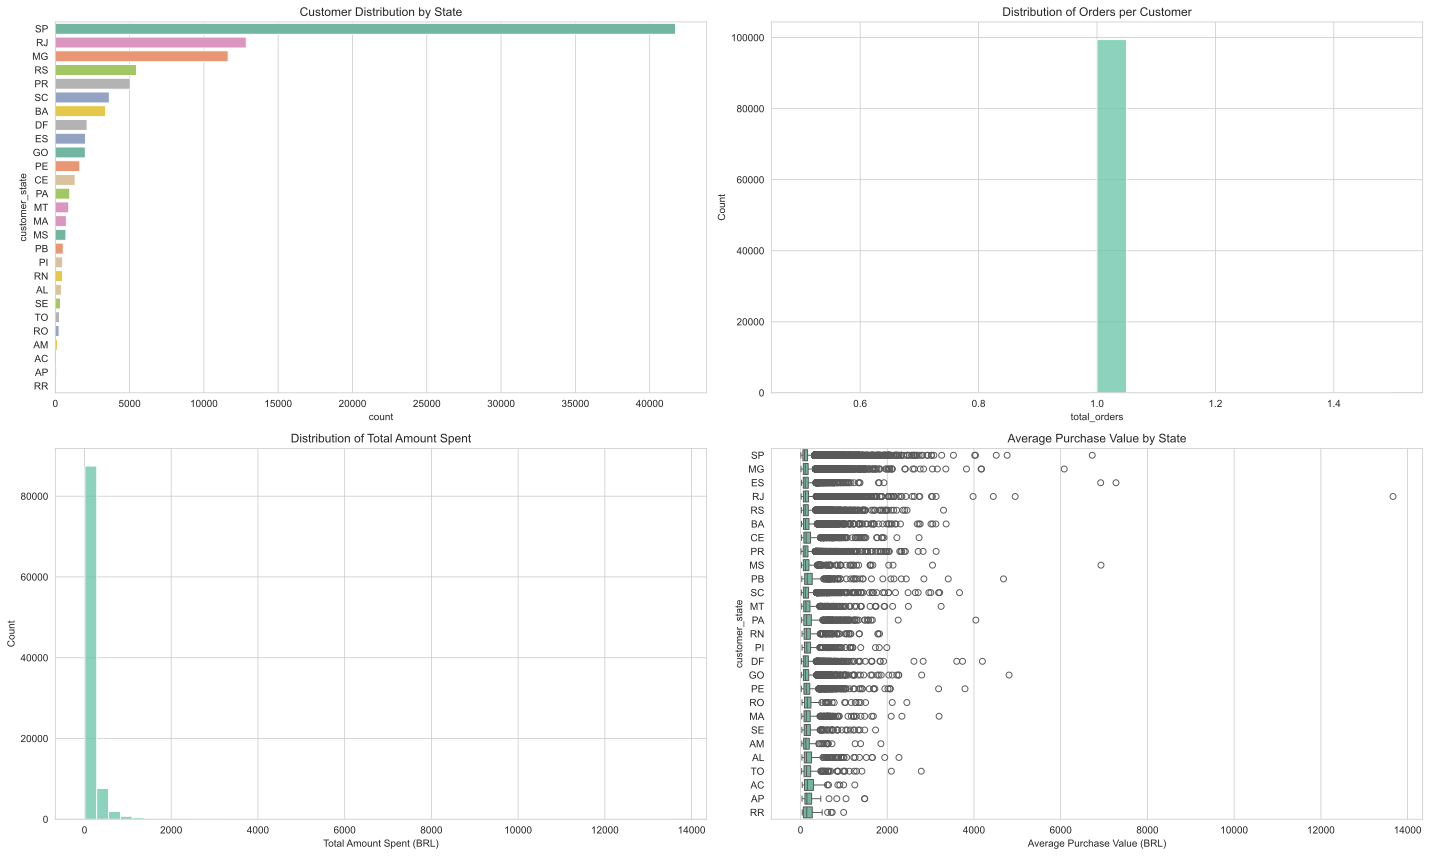

In [5]:
# Query customer data
customer_query = """
SELECT * FROM customer_overview
"""
customer_df = pd.read_sql(customer_query, engine)

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Customer distribution by state
sns.countplot(data=customer_df, y='customer_state', order=customer_df['customer_state'].value_counts().index, ax=ax1,hue='customer_state', palette='Set2')
ax1.set_title('Customer Distribution by State')

# Orders per customer
sns.histplot(data=customer_df, x='total_orders', bins=20, ax=ax2)
ax2.set_title('Distribution of Orders per Customer')

# Total spent distribution
sns.histplot(data=customer_df, x='total_spent', bins=50, ax=ax3)
ax3.set_title('Distribution of Total Amount Spent')
ax3.set_xlabel('Total Amount Spent (BRL)')

# Average purchase value
customer_df['avg_purchase'] = customer_df['total_spent'] / customer_df['total_orders']
sns.boxplot(data=customer_df, y='customer_state', x='avg_purchase', ax=ax4)
ax4.set_title('Average Purchase Value by State')
ax4.set_xlabel('Average Purchase Value (BRL)')

plt.tight_layout()
plt.savefig('../plots/customer_analysis.png', dpi=300)   
plt.show()

## 4. Seller Analysis
Analyzing seller performance and distribution

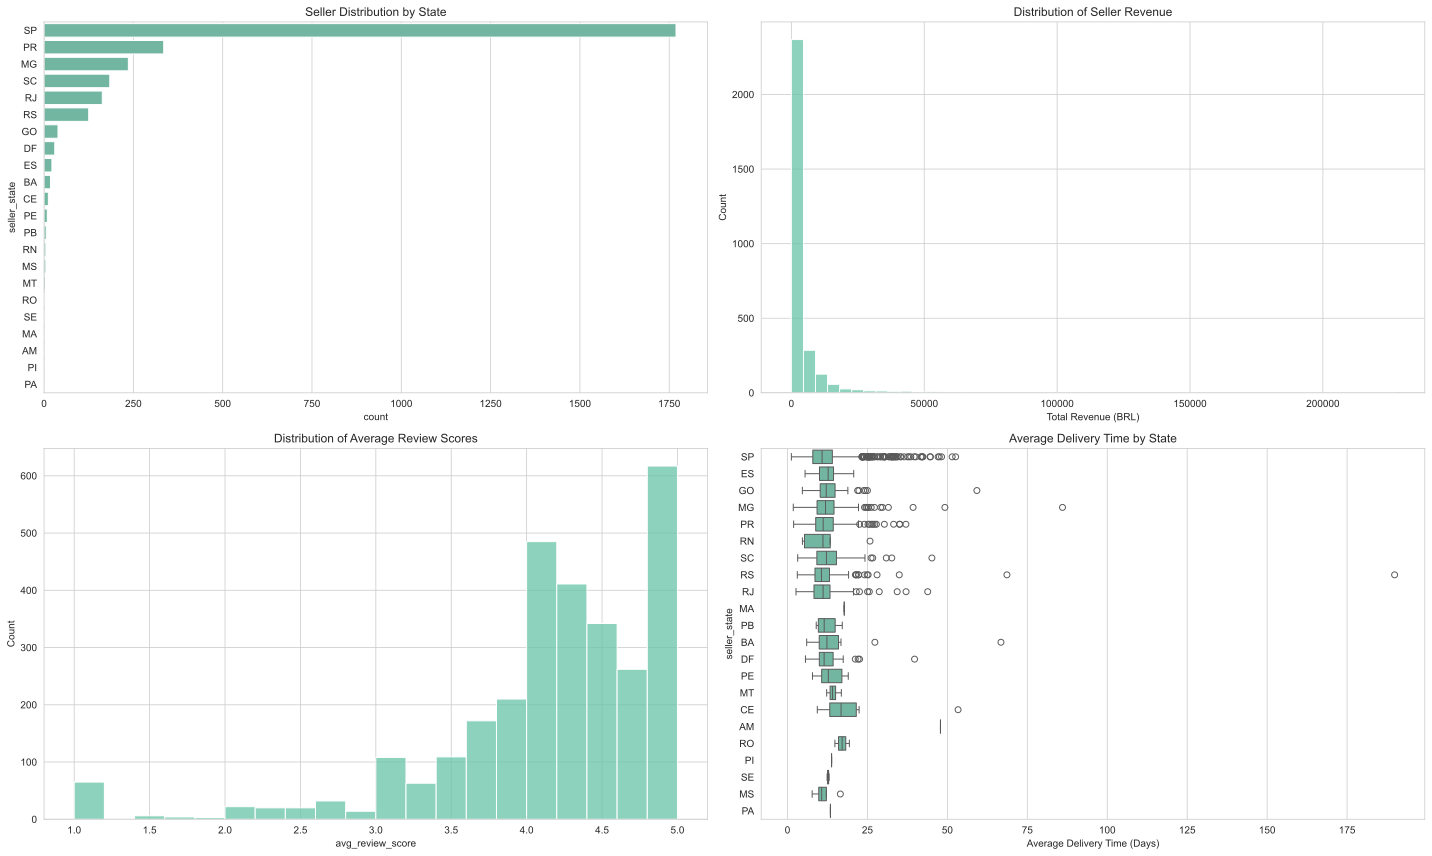

In [6]:
# Query seller data
seller_query = """
SELECT * FROM seller_performance
"""
seller_df = pd.read_sql(seller_query, engine)

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Seller distribution by state
sns.countplot(data=seller_df, y='seller_state', order=seller_df['seller_state'].value_counts().index, ax=ax1)
ax1.set_title('Seller Distribution by State')

# Revenue distribution
sns.histplot(data=seller_df, x='total_revenue', bins=50, ax=ax2)
ax2.set_title('Distribution of Seller Revenue')
ax2.set_xlabel('Total Revenue (BRL)')

# Average review score distribution
sns.histplot(data=seller_df, x='avg_review_score', bins=20, ax=ax3)
ax3.set_title('Distribution of Average Review Scores')

# Delivery time distribution
sns.boxplot(data=seller_df, y='seller_state', x='avg_delivery_time_days', ax=ax4)
ax4.set_title('Average Delivery Time by State')
ax4.set_xlabel('Average Delivery Time (Days)')

plt.tight_layout()
plt.savefig('../plots/seller_analysis.png', dpi=300)
plt.show()

## 5. Order and Delivery Analysis
Analyzing order processing and delivery performance

In [7]:
try:
    # Query order data with proper filtering
    order_query = """
    SELECT 
        *,
        CASE 
            WHEN order_status = 'delivered' AND order_delivered_customer_date <= order_estimated_delivery_date THEN TRUE
            ELSE FALSE
        END as delivered_on_time
    FROM 
        order_details
    WHERE 
        order_purchase_timestamp >= NOW() - INTERVAL '1 year'
    """
    order_df = pd.read_sql(order_query, engine)
    
    # Verify data
    print(f"Number of orders: {len(order_df)}")
    if len(order_df) == 0:
        raise ValueError("No order data retrieved from database")
    
    print("\nFirst few rows of order data:")
    print(order_df.head())
    print("\nOrder status distribution:")
    print(order_df['order_status'].value_counts())
    
    # Data preprocessing
    order_df['delivery_time_days'] = order_df['delivery_time_days'].fillna(-1)  # Mark missing as -1
    order_df['items_count'] = order_df['items_count'].fillna(0)
    
    # Create visualizations
    plt.style.use('seaborn')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Order status distribution
    status_order = order_df['order_status'].value_counts().index
    sns.countplot(data=order_df, 
                 y='order_status', 
                 order=status_order,
                 ax=ax1)
    ax1.set_title('Distribution of Order Status', pad=20)
    ax1.set_xlabel('Number of Orders')
    
    # Delivery time distribution (only for delivered orders)
    delivered_orders = order_df[order_df['delivery_time_days'] >= 0]
    sns.histplot(data=delivered_orders[delivered_orders['delivery_time_days'] <= delivered_orders['delivery_time_days'].quantile(0.99)], 
                x='delivery_time_days', 
                bins=50, 
                ax=ax2)
    ax2.set_title('Distribution of Delivery Times (excluding outliers)', pad=20)
    ax2.set_xlabel('Delivery Time (Days)')
    
    # On-time delivery ratio (only for delivered orders)
    delivered_orders = order_df[order_df['order_status'] == 'delivered']
    sns.countplot(data=delivered_orders, 
                 x='delivered_on_time',
                 ax=ax3)
    ax3.set_title('On-time vs Delayed Deliveries', pad=20)
    ax3.set_xlabel('Delivered On Time')
    
    # Items per order distribution
    sns.histplot(data=order_df[order_df['items_count'] > 0], 
                x='items_count', 
                bins=20, 
                ax=ax4)
    ax4.set_title('Items per Order Distribution', pad=20)
    ax4.set_xlabel('Number of Items')
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'order_analysis.svg'), 
                dpi=300, 
                bbox_inches='tight',
                format='svg')
    plt.show()
    
    # Print summary statistics
    print("\nOrder Summary Statistics:")
    print(f"Total number of orders: {len(order_df):,}")
    print(f"Orders by status:")
    status_counts = order_df['order_status'].value_counts()
    status_percentages = order_df['order_status'].value_counts(normalize=True) * 100
    for status in status_counts.index:
        print(f"{status}: {status_counts[status]:,} ({status_percentages[status]:.1f}%)")
    
    delivered_orders = order_df[order_df['order_status'] == 'delivered']
    if len(delivered_orders) > 0:
        print(f"\nFor delivered orders:")
        print(f"Average delivery time: {delivered_orders['delivery_time_days'].mean():.1f} days")
        print(f"Median delivery time: {delivered_orders['delivery_time_days'].median():.1f} days")
        on_time_pct = (delivered_orders['delivered_on_time'].sum() / len(delivered_orders)) * 100
        print(f"On-time delivery rate: {on_time_pct:.1f}%")
    
    print(f"\nItems per order:")
    print(f"Average: {order_df['items_count'].mean():.1f}")
    print(f"Median: {order_df['items_count'].median():.0f}")
    print(f"Max: {order_df['items_count'].max():.0f}")
    
except Exception as e:
    print(f"Error in order analysis: {str(e)}")
    raise

Number of orders: 0
Error in order analysis: No order data retrieved from database


ValueError: No order data retrieved from database

## 6. Payment Analysis
Analyzing payment methods and patterns

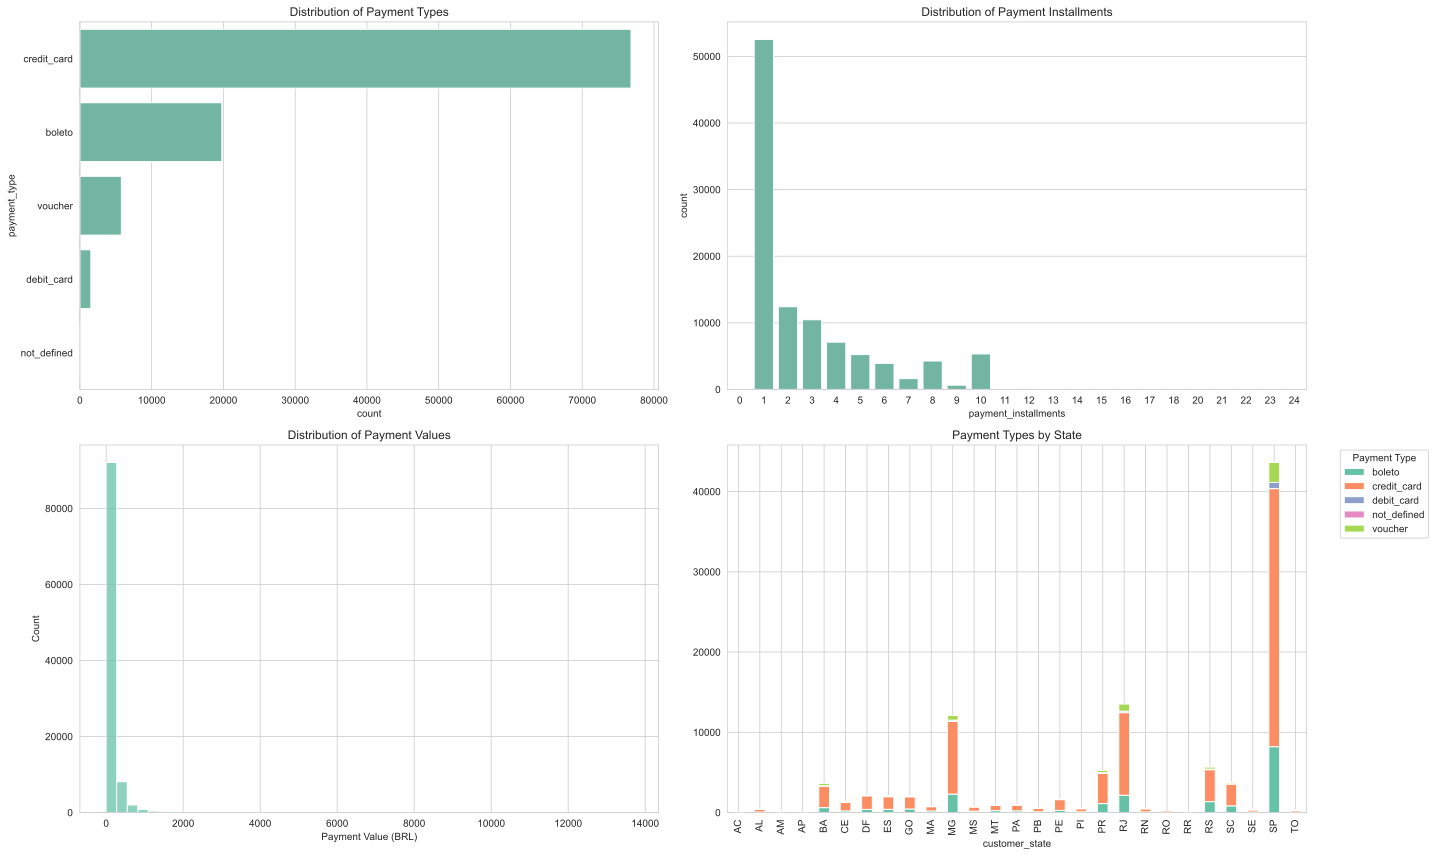

In [ ]:
# Query payment data
payment_query = """
SELECT * FROM payment_analysis
"""
payment_df = pd.read_sql(payment_query, engine)

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Payment type distribution
sns.countplot(data=payment_df, y='payment_type', ax=ax1)
ax1.set_title('Distribution of Payment Types')

# Payment installments distribution
sns.countplot(data=payment_df, x='payment_installments', ax=ax2)
ax2.set_title('Distribution of Payment Installments')

# Payment value distribution
sns.histplot(data=payment_df, x='payment_value', bins=50, ax=ax3)
ax3.set_title('Distribution of Payment Values')
ax3.set_xlabel('Payment Value (BRL)')

# Payment type by state
payment_state = payment_df.groupby(['customer_state', 'payment_type']).size().unstack()
payment_state.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_title('Payment Types by State')
ax4.legend(title='Payment Type', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig('../plots/payment_analysis.png', dpi=300)
plt.show()

## Summary Insights
This analysis provides valuable insights into the Brazilian E-commerce marketplace:

1. Product categories have varying levels of success in terms of revenue and customer satisfaction
2. Customer distribution is concentrated in certain states
3. Seller performance varies significantly by region
4. Delivery times show room for improvement in certain areas
5. Payment preferences vary by region and transaction value